# TensorFlow Similarity Self-Supervised Learning Hello World using TPU

This notebook is mostly based on [unsupervised_hello_world.ipynb](https://github.com/tensorflow/similarity/blob/master/examples/unsupervised_hello_world.ipynb) from the [Tensorflow Similarity github](https://github.com/tensorflow/similarity) with changes made to run with TPU on Google Colab.

Before running, be sure to switch runtime type to use TPU as hardware accelerator.

For detailed explanations of the contrastive learning task, please refer to the original [notebook](https://github.com/tensorflow/similarity/blob/master/examples/unsupervised_hello_world.ipynb).


<table class="tfo-notebook-buttons" align="left">
  <!-- td>
    <a target="_blank" href="https://colab.research.google.com/github/kechan/notebooks/blob/TPU_unsupervised_hello_world.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td -->
  <a href="https://colab.research.google.com/github/kechan/notebooks/blob/master/TPU_unsupervised_hello_world.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
  <td>
    <a target="_blank" href="https://github.com/kechan/notebooks/blob/master/TPU_unsupervised_hello_world.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Initial setup

### General Setup

In [1]:
import gc
import os
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
# install TF addons if needed
try:
    import tensorflow_addons as tfa  # main package
except ModuleNotFoundError:
    !pip install tensorflow-addons
    import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 5.6 MB/s 


In [ ]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip -q install tensorflow_similarity
    import tensorflow_similarity as tfsim

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

In [6]:
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

In [7]:
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.8.0
TensorFlow Similarity 0.15.5


### TPU Setup

In [8]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
  print('ERROR: Not connected to a TPU runtime. Please switch runtime type to use TPU as hardware accelerator')
  tpu = None

Running on TPU  ['10.122.217.170:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.122.217.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.217.170:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


### Dataset Preperation

The following section:
* Loads the [CIFAR10](https://www.tensorflow.org/datasets/catalog/cifar10) data from tensorflow datasets.
* Creates the train, val, test, and query/index splits.

In [9]:
DATA_PATH = Path("tfsim_contrastive_model")
if not DATA_PATH.exists():
    DATA_PATH.mkdir(parents=True)

#### Load The Raw Data

We are going to load the [CIFAR10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset. This dataset is often used in the self-supervised papers, enabling us to reproduce the published results. 

#### Auth for GCS
You must create and have access to a google cloud bucket storage. Please google for instruction.

In [10]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [12]:
google_cloud_bucket_name = 'ai-tests'    # change_me

In [ ]:
data_dir = f'gs://{google_cloud_bucket_name}/tfsim_contrastive_model' # TPU env can't read from local dir while dealing with tensors

try:
  ((x_raw_train, y_raw_train), (x_test, y_test)), ds_info = tfds.load(
      "cifar10",
      split=["train", "test"],
      data_dir=data_dir,   
      batch_size=-1,
      shuffle_files=True,
      as_supervised=True,
      with_info=True,
  )
except Exception as ex:
  print(f"TPU env is unable to access {data_dir} directory")
  # print(ex)   # uncomment this to see the full error if you are interested.

#### **Create Data Splits**
For simplicity in exploring TPU (with colab), we will not be creating any splits, because we will skip doing the callback computing metrics using query/index. We will be happy just looking at the test loss as the only metrics for now.

**Note**: The original splitting code would run very very slowly with TPU for some reasons. There could be some efficient code to do splits.


## Self-Supervised Training Setup

This following section:
* Sets the training parameters used for building the different architectures.
* Creates a train and test tf.data.Dataset.
* Visualizes the pairs of augmented views from a single batch.

### Self-Supervised Algorithm Selection
[TensorFlow Similarity](https://github.com/tensorflow/similarity) currently supports three different self-supervised models.
* [SimCLR](http://arxiv.org/abs/2002.05709): Only requires the Backbone and the projector and uses a contrastive cross-entropy loss.
* [SimSiam](https://arxiv.org/abs/2011.10566): Requires the Backbone, projector, and predictor and only compares the cosine distance between augmented views from the same example.
* [Barlow Twins](https://arxiv.org/abs/2103.03230): Only requires the Backbone and the projector and uses a loss that compares the feature covariance instead of contrasting the views.

The `ALGORITHM` parameter is used throughout this notebook to set up the various architectures and the parameters defined below are set up to reproduce the results published in the papers. 

In [16]:
ALGORITHM = "simclr"  # @param ["barlow", "simsiam", "simclr"]

### Training Parameter Setup

In [18]:
CIFAR_IMG_SIZE = 32

if ALGORITHM == "simsiam":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 800
    PRE_TRAIN_STEPS_PER_EPOCH = len_train // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 3e-2 * int(BATCH_SIZE / 256)
    WARMUP_LR = 0.0
    WARMUP_STEPS = 0
    DIM = 2048  # The layer size for the projector and predictor models.
elif ALGORITHM == "barlow":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 800
    PRE_TRAIN_STEPS_PER_EPOCH = len_train // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule.
    WARMUP_LR = 0.0
    WARMUP_STEPS = 1000
    DIM = 2048  # The layer size for the projector and predictor models.
elif ALGORITHM == "simclr":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 800
    PRE_TRAIN_STEPS_PER_EPOCH = x_raw_train.shape[0] // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = x_test.shape[0] // BATCH_SIZE
    WEIGHT_DECAY = 5e-4
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule, see section B.1 in the paper.
    TEMPERATURE = 0.5 # Tuned for CIFAR10, see section B.9 in the paper.
    DIM = 2048  # The layer size for the projector and predictor models.

### Augmented View Configuration

Self-supervised networks require at least two augmented "views" of each example. This can be created using a DataSet and an augmentation function. The DataSet treats each example in the batch as its own class and then the augment function produces two separate views for each example. 

This means the resulting batch will yield tuples containing the two views, i.e., `Tuple[(BATCH_SIZE, 32, 32, 3), (BATCH_SIZE, 32, 32, 3)]`. TODO make this clearer, "each example in the batch is of this type"

TensorFlow Similarity provides several random augmentation functions, and here we combine augmenters from the simCLR module to replicate the augmentations used in simsiam. This augmenter returns values between [0, 1], but our ResNet backbone model expects the values to be between [0, 255] so we also scale the final output values in the augmentation function.

In [19]:
@tf.function
def simsiam_augmenter(img, blur=True, area_range=(0.2, 1.0)):
    """SimSiam augmenter.

    The SimSiam augmentations are based on the SimCLR augmentations, but have
    some important differences.
    * The crop area lower bound is 20% instead of 8%.
    * The color jitter and grayscale are applied separately instead of together.
    * The color jitter ranges are much smaller.
    * Blur is not applied for the cifar10 dataset.

    args:
        img: Single image tensor of shape (H, W, C)
        blur: If true, apply blur. Should be disabled for cifar10.
        area_range: The upper and lower bound of the random crop percentage.

    returns:
        A single image tensor of shape (H, W, C) with values between 0.0 and 1.0.
    """
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.simclr.crop_and_resize(
        img, CIFAR_IMG_SIZE, CIFAR_IMG_SIZE, area_range=area_range
    )
    img /= 255.0
    # random color jitter
    def _jitter_transform(x):
        return tfsim.augmenters.simclr.color_jitter_rand(
            x,
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.1),
            "simclrv2",
        )

    img = tfsim.augmenters.simclr.random_apply(_jitter_transform, p=0.8, x=img)

    # # random grayscale
    def _grascayle_transform(x):
        return tfsim.augmenters.simclr.to_grayscale(x)

    img = tfsim.augmenters.simclr.random_apply(_grascayle_transform, p=0.2, x=img)

    # optional random gaussian blur
    if blur:
        img = tfsim.augmenters.simclr.random_blur(img, p=0.5)

    # random horizontal flip
    img = tf.image.random_flip_left_right(img)
    img = tf.clip_by_value(img, 0.0, 1.0)

    return img


@tf.function()
def process(img):
    # The augmenters return scaled values between [0,1]
    view1 = simsiam_augmenter(img, blur=False)
    view2 = simsiam_augmenter(img, blur=False)
    # The ResNet model scales internally and expects the inputs to be between [0, 255]
    return (view1 * 255.0, view2 * 255.0)


In [20]:
train_ds = tf.data.Dataset.from_tensor_slices(x_raw_train)
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)   # mainly data aug and 2 views generations.
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)     # drop_remainder is important as part of a workaround to a problem.
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(x_test)
test_ds = test_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

### Visualize Augmentations

The following cell plots the pairs of augmented views side by side. This can be a useful sanity check as many augmentation functions are set up for the larger ImageNet examples and can be overly aggressive for smaller images found in CIFAR.

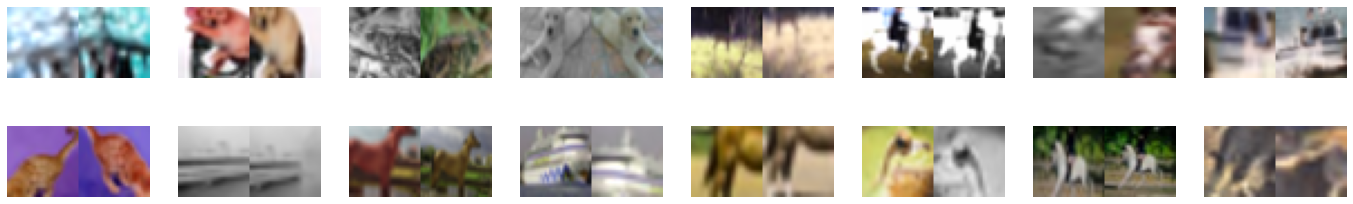

In [21]:
tfsim.visualization.visualize_views(
    views=next(train_ds.as_numpy_iterator()),
    num_imgs=16,
    views_per_col=8,
    max_pixel_value=255.0,
)

## Contrastive Model Setup
 
The following section creates the sub-models used by the different algorithms. There are various architectures for building self-supervised models which may include some of the following:
* **Backbone**: This is the base model and is typically an existing architecture like ResNet or EfficientNet.
* **Projector**: This is a small multi-layer Neural Net and provides the embedding features at the end of training.
* **Predictor**: This model is used by BYOL and SimSiam and provides an additional small multi-layer Neural Net.
 
Typically, the projector and predictor networks are only 2 or 3 layers with batch normalization. While some [papers](https://arxiv.org/abs/2010.10241) claim that batch normalization is not required, the [SimSiam paper](https://arxiv.org/abs/2011.10566) shows empirically that the batch normalization is critical to prevent the model from collapsing to a degenerate solution.
 
Additionally, many papers show a single `encoder` block, but this often contains both the `Backbone` and the `Projector` network.
 
![contrastive_loss_functions.png](https://raw.githubusercontent.com/tensorflow/similarity/master/assets/images/contrastive_loss_functions.png)
 
The diagram above shows three self-supervised architectures supported by TensorFlow Similarity. As you can see, they all share a common structure:
* Processing multiple views of the same example.
* Using a backbone model for learning the representation output. 
* Using a projector for the embedding output.
* Additionally, note that the loss is symmetric, so we compute it twice during each step. First for view 1 and then a second time for view 2. These two losses are then summed up to compute the final aggregate loss.
 
However, there are some key differences including:
 
* The loss is different in each of the three architectures.
    * SimCLR uses a contrastive cross-entropy loss where each example's pair of augmented views should be close to 1 and all other views should be close to zero. Including the negative examples in the loss is part of the reason that SimCLR benefits from larger batch sizes.
    * SimSiam only compares the cosine distance between the pairs of augmented views. This means there are no negative examples in the loss, and consequently, the batch size can be much smaller.
    * Barlow Twins attempts to learn the cross-correlation between the embedding features, where similar feature activations between two views will produce small values along the diagonal and a positive penalty is applied for positive or negative off-diagonal correlations. In this way the diagonal represents features that are invariant to augmented views, while the off-diagonal values encourage the features to be independent of each other.
* The SimSiam architecture requires an additional Predictor network.
* The SimSiam architecture also uses a stop-gradient to ensure that we only flow the gradient from the target view.
 
 
TensorFlow Similarity offers a common set of modules to construct the common parts, and implement the parts which are specific to popular self-supervised algorithms on top of it. Attempting to offer flexibility to add your own algorithm or reuse proven architectures that the results we have reproduced. 

### Backbone Model

The backbone uses a custom version of ResNet18 in order to reproduce the SimSiam CIFAR10 results.
 
<div class="alert alert-block alert-info"> <b>NOTE</b> The ResNet models provided in `tf.keras.applications` use larger `[(1x1), (3x3), (1x1)]` blocks that can't be used to reproduce the SimSiam CIFAR10 results. </div>

In [22]:
def get_backbone(
    img_size, activation="relu", preproc_mode="torch"
):
    input_shape = (img_size, img_size, 3)
    backbone = tfsim.architectures.ResNet18Sim(
        input_shape,
        include_top=False,  # Take the pooling layer as the output.
        pooling="avg",      # Can change to use `gem` -> GeneralizedMeanPooling2D
        # gem_p=3.0,        # Increase the contrast between activations in the feature map.
        preproc_mode="torch",
    )
    return backbone

if tpu is not None:
  with tpu_strategy.scope():
    backbone = get_backbone(CIFAR_IMG_SIZE)
backbone.summary()

Model: "resnet18sim"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet18 (Functional)       (None, 4, 4, 512)         11182784  
                                                                 
 avg_pool (GlobalAveragePool  (None, 512)              0         
 ing2D)                                                          
                                                                 
Total params: 11,182,784
Trainable params: 11,173,056
Non-trainable params: 9,728
_________________________________________________________________


### Projector Model
 
This MLP is common to all the self-supervised models and is typically a stack of 3 layers of the same size. However, SimSiam only uses 2 layers for the smaller CIFAR images. Having too much capacity in the models can make it difficult for the loss to stabilize and converge.
 
Additionally, the SimSiam paper found that disabling the center and scale parameters can lead to a small boost in the final loss.
 
<div class="alert alert-block alert-info"> <b>NOTE</b> This is the model output that is returned by `ContrastiveModel.predict()` and represents the distance based embedding. This embedding can be used for the KNN lookups and matching classification metrics. However, when using the pre-train model for downstream tasks, only the `ContrastiveModel.backbone` is used. </div>

In [23]:
def get_projector(input_dim, dim, activation="relu", num_layers: int = 3):
    inputs = tf.keras.layers.Input((input_dim,), name="projector_input")
    x = inputs
    
    for i in range(num_layers - 1):
        x = tf.keras.layers.Dense(
            dim,
            use_bias=False,
            kernel_initializer=tf.keras.initializers.LecunUniform(),
            name=f"projector_layer_{i}",
        )(x)
        x = tf.keras.layers.BatchNormalization(
            epsilon=1.001e-5, name=f"batch_normalization_{i}"
        )(x)
        x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_{i}")(
            x
        )
    x = tf.keras.layers.Dense(
        dim,
        use_bias=False,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="projector_output",
    )(x)
    x = tf.keras.layers.BatchNormalization(
        epsilon=1.001e-5,
        center=False,  # Page:5, Paragraph:2 of SimSiam paper
        scale=False,  # Page:5, Paragraph:2 of SimSiam paper
        name=f"batch_normalization_ouput",
    )(x)
    # Metric Logging layer. Monitors the std of the layer activations. 
    # Degnerate solutions colapse to 0 while valid solutions will move 
    # towards something like 0.0220. The actual number will depend on the layer size.
    o = tfsim.layers.ActivationStdLoggingLayer(name="proj_std")(x)
    projector = tf.keras.Model(inputs, o, name="projector")
    return projector

if tpu is not None:
  with tpu_strategy.scope():
    projector = get_projector(input_dim=backbone.output.shape[-1], dim=DIM, num_layers=2)
    
projector.summary()

Model: "projector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 projector_input (InputLayer  [(None, 512)]            0         
 )                                                               
                                                                 
 projector_layer_0 (Dense)   (None, 2048)              1048576   
                                                                 
 batch_normalization_0 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 relu_activation_0 (Activati  (None, 2048)             0         
 on)                                                             
                                                                 
 projector_output (Dense)    (None, 2048)              4194304   
                                                         

### Predictor model

The predictor model is used by [BYOL](https://arxiv.org/abs/2006.07733) and [SimSiam](https://arxiv.org/abs/2011.10566), and is an additional 2 layer MLP containing a bottleneck in the hidden layer.

In [24]:
def get_predictor(input_dim, hidden_dim=512, activation="relu"):
    inputs = tf.keras.layers.Input(shape=(input_dim,), name="predictor_input")
    x = inputs

    x = tf.keras.layers.Dense(
        hidden_dim,
        use_bias=False,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="predictor_layer_0",
    )(x)
    x = tf.keras.layers.BatchNormalization(
        epsilon=1.001e-5, name="batch_normalization_0"
    )(x)
    x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_0")(x)

    x = tf.keras.layers.Dense(
        input_dim,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="predictor_output",
    )(x)
    # Metric Logging layer. Monitors the std of the layer activations. 
    # Degnerate solutions colapse to 0 while valid solutions will move 
    # towards something like 0.0220. The actual number will depend on the layer size.
    o = tfsim.layers.ActivationStdLoggingLayer(name="pred_std")(x)
    predictor = tf.keras.Model(inputs, o, name="predictor")
    return predictor

if tpu is not None:
  with tpu_strategy.scope():
    predictor = get_predictor(input_dim=DIM, hidden_dim=512)
    
predictor.summary()

Model: "predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 predictor_input (InputLayer  [(None, 2048)]           0         
 )                                                               
                                                                 
 predictor_layer_0 (Dense)   (None, 512)               1048576   
                                                                 
 batch_normalization_0 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 relu_activation_0 (Activati  (None, 512)              0         
 on)                                                             
                                                                 
 predictor_output (Dense)    (None, 2048)              1050624   
                                                         

## Self-Supervised Algorithms
 
The following section builds the `ContrastiveModel` based on the `ALGORITHM` set at the start of the Notebook.
 
The model training is very sensitive to the learning rate decay and weight decay.
* **SimSiam**: Requires using SGD with weight decay from TF Addons. Adding weight decay as a kernel_regularizer doesn't seem to be able to reproduce the published results in the paper.
* **Barlow Twins**: We can use LAMB and avoid the need for the learning rate schedule. Lamb is similar to the LARS optimizer used in the Barlow paper, but includes the use of ADAM. Alternatively, we can use SGD but the optimizer requires a warm up period, otherwise the loss explodes.
* **SimCLR**: We can also use LAMB as the original paper uses LARS. However, LAMB seems to require smaller learning rates than shown for LARS in the original paper.

In [25]:
if ALGORITHM == "simsiam":
    loss = tfsim.losses.SimSiamLoss(projection_type="cosine_distance", name=ALGORITHM)

    if tpu is not None:
      with tpu_strategy.scope():
        contrastive_model = tfsim.models.ContrastiveModel(
            backbone=backbone,
            projector=projector,
            predictor=predictor,  # NOTE: simiam requires predictor model.
            algorithm=ALGORITHM,
            name=ALGORITHM,
        )
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=INIT_LR,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    wd_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=WEIGHT_DECAY,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    optimizer = tfa.optimizers.SGDW(
        learning_rate=lr_decayed_fn, weight_decay=wd_decayed_fn, momentum=0.9
    )
elif ALGORITHM == "barlow":
    loss = tfsim.losses.Barlow(name=ALGORITHM)

    if tpu is not None:
      with tpu_strategy.scope():
        contrastive_model = tfsim.models.ContrastiveModel(
            backbone=backbone,
            projector=projector,
            algorithm="barlow",
        )
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
elif ALGORITHM == "simclr":
    loss = tfsim.losses.SimCLRLoss(name=ALGORITHM, temperature=TEMPERATURE)

    if tpu is not None:
      with tpu_strategy.scope():
        contrastive_model = tfsim.models.ContrastiveModel(
            backbone=backbone,
            projector=projector,
            algorithm=ALGORITHM,
        )
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
else:
    raise ValueError(f"{ALGORITHM} is not supported.")

### Compile

In [26]:
if tpu is not None:
  with tpu_strategy.scope():
    contrastive_model.compile(
        optimizer=optimizer,
        loss=loss,
    )

### Callbacks

We track the training using several callbacks.

* **EvalCallback** creates an index at the end of each epoch and provides a proxy for the nearest neighbor matching classification using `binary_accuracy`.
* **TensordBoard** and **ModelCheckpoint** are provided for tracking the training progress.

In [27]:
log_dir = f'gs://{google_cloud_bucket_name}/models/logs/{loss.name}_{time.time()}'
chkpt_dir = f'gs://{google_cloud_bucket_name}/models/checkpoints/{loss.name}_{time.time()}'

# log_dir = DATA_PATH / "models" / "logs" / f"{loss.name}_{time.time()}"
# chkpt_dir = DATA_PATH / "models" / "checkpoints" / f"{loss.name}_{time.time()}"

mcp = tf.keras.callbacks.ModelCheckpoint(
    filepath=chkpt_dir,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
)

## Model Training
 
The model training provides a number of metrics.
- **loss**: This represents the total loss over the contrastive batch. Separate contrastive and regularization losses will also be shown if there are trainable variables in the model layers.
- **proj_std and pred_std**: These are added as metric logging layers in the model and show the std of the activations of the final layer in the projector or predictor models.
- **binary_accuracy**: This is the nearest neighbor matching classification accuracy. A new index is built at the end of each epoch and the accuracy is computed using the query and index examples.
 
**Notes: Move this to the evaluation section in the paper.**
- SGDW or LAMB seems to be required to prevent the loss from becoming unstable.
- Per layer kernel_regularization with weight decay doesn't work.
- The kernel initialization seems very critical. Smaller, uniform initialization schemes like Lecunn seem to work best.
- The projector is a more stable output for the KNN match metrics. The predictor output is typically worse and higher variance.
- The LR and weight decay schedule seem important. The loss becomes unstable if the updates are too large later in training.
- Too much capacity in the combined model and the training won't converge... same goes for too little capacity.
- Augmentation is critical, but too much augmentation and the model won't converge.

In [29]:
history = contrastive_model.fit(
    train_ds,
    epochs=PRE_TRAIN_EPOCHS,
    steps_per_epoch=PRE_TRAIN_STEPS_PER_EPOCH,
    validation_data=test_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
    # callbacks=[evb, tbc, mcp],
    callbacks=[mcp]
)

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(history.history["loss"])
plt.grid()
plt.title(f"{loss.name} - loss")

plt.subplot(1,3,2)
plt.plot(history.history["proj_std"], label="proj")
if "pred_std" in history.history:
    plt.plot(history.history["pred_std"], label="pred")
plt.grid()
plt.title(f"{loss.name} - std metrics")
plt.legend()

# plt.subplot(1,3,3)
# plt.plot(history.history["binary_accuracy"], label="acc")
# plt.grid()
# plt.title(f"{loss.name} - match metrics")
# plt.legend()

plt.subplot(1,3,3)
plt.plot(history.history["val_loss"], label="val_loss")
plt.grid()
plt.title(f"{loss.name} - val loss")
plt.legend()

plt.show()